# Network Analysis Comparison between OSM and PyPSA Eur Data

This jupyter notebook explores a comparison between the OSM and PyPSA Eur data.

To run this notebook successfully, `osm_data` and `pypsa_eur_data` will need to be downloaded. The file size for `osm_data` and `pypsa_eur_data` are 3GB and 500MB respectively.
The files are currently stored in a google drive. You can download the files using their respective IDs.

drive link for osm_data: https://drive.google.com/file/d/1AuUnJHO8ODyWsQBbdDyq8Bktw78W0219/view?usp=drive_link

id for osm_data: 1AuUnJHO8ODyWsQBbdDyq8Bktw78W0219

drive link for pypsa_eur data: https://drive.google.com/file/d/1EKuKtqQkewwPXyZDh9zgKwsfmwODCQEV/view?usp=drive_link

id for pypsa_eur-Eur data: 1EKuKtqQkewwPXyZDh9zgKwsfmwODCQEV

## Download files

If you have the data already, you can skip this section.

In [1]:
# installing gdown. gdown is a python library that will be used to download the files from google drive using the ID
!pip install gdown -qq

In [2]:
# # download osm_data
# !gdown "1AuUnJHO8ODyWsQBbdDyq8Bktw78W0219" -O elec-osm.nc

# # download pypsa_eur_data
# !gdown "1EKuKtqQkewwPXyZDh9zgKwsfmwODCQEV" -0 elec-entsoe.nc

## Network Analysis

In [3]:
# loading required libraries
import pypsa
import geopy
import matplotlib.pyplot as plt
import time

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 1000)

%matplotlib inline

In [4]:
# loading the data into variables
entsoe = pypsa.Network("elec-entsoe.nc")
osm = pypsa.Network("elec-osm.nc")

INFO:pypsa.io:Imported network elec-entsoe.nc has buses, carriers, generators, lines, links, loads, storage_units, transformers
INFO:pypsa.io:Imported network elec-osm.nc has buses, carriers, generators, lines, links, loads, storage_units, transformers


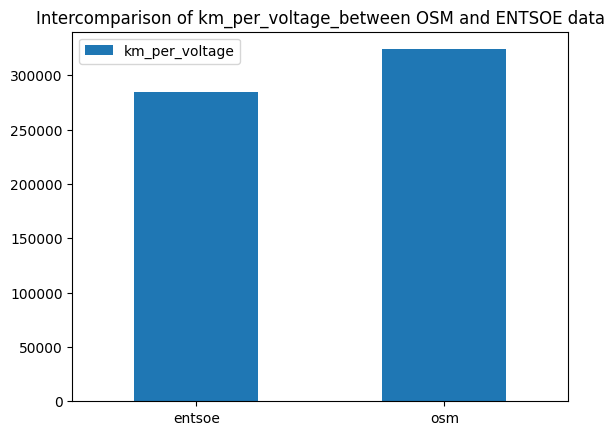

In [5]:
# calculate km_per_voltage for volatage greater than 220v and only AC lines for both the OSM data and PyPSA-Eur data

entsoe_km_per_voltage = sum(entsoe.lines['length'] * entsoe.lines['num_parallel'])
osm_220 = osm.lines[(osm.lines.v_nom > 220.0) & (osm.lines.dc == False)]
osm_km_per_voltage = sum(osm_220['length'] * osm_220['num_parallel'])

df = pd.DataFrame({'lab':['entsoe', 'osm'], 'km_per_voltage':[entsoe_km_per_voltage, osm_km_per_voltage]})

ax = df.plot.bar(x='lab', y='km_per_voltage', rot=0, xlabel='', title="Intercomparison of km_per_voltage_between OSM and ENTSOE data")

In [6]:
# calculate km_per_voltage volatage greater than 220v and only AC lines for both the OSM data and PyPSA-Eur data to get a country comparison plot

osm.lines['km_per_voltage'] = (osm.lines['length'] * osm.lines['num_parallel']) / 1e6
osm_country_stats_km_per_voltage = osm.lines[(osm.lines.v_nom > 220.0) & (osm.lines.dc == False)][['country', 'km_per_voltage']].groupby(['country'])[['km_per_voltage']].sum()

entsoe_merged = entsoe.lines.merge(entsoe.buses['country'].reset_index(), how='left', left_on='bus0', right_on='Bus')

entsoe_merged['km_per_voltage'] = (entsoe_merged['length'] * entsoe_merged['num_parallel']) / 1e6
entsoe_merged_country_stats_km_per_voltage = entsoe_merged[(entsoe_merged.v_nom > 220.0)][['country', 'km_per_voltage']].groupby(['country'])[['km_per_voltage']].sum()

entsoe_merged_country_stats_km_per_voltage.reset_index(inplace=True)
osm_country_stats_km_per_voltage.reset_index(inplace=True)

In [7]:
# checking to see the country available in OSM data that is not in PyPSA-Eur data

d1 = osm_country_stats_km_per_voltage['country'].to_dict()
d2 = entsoe_merged_country_stats_km_per_voltage['country'].to_dict()

for idx in d1.values():
    if idx not in d2.values():
        print (idx)

LU


In [8]:
# select data without 'LU' to avoid conflict in the plots
osm_country_stats_km_per_voltage = osm_country_stats_km_per_voltage[osm_country_stats_km_per_voltage['country'] != 'LU']

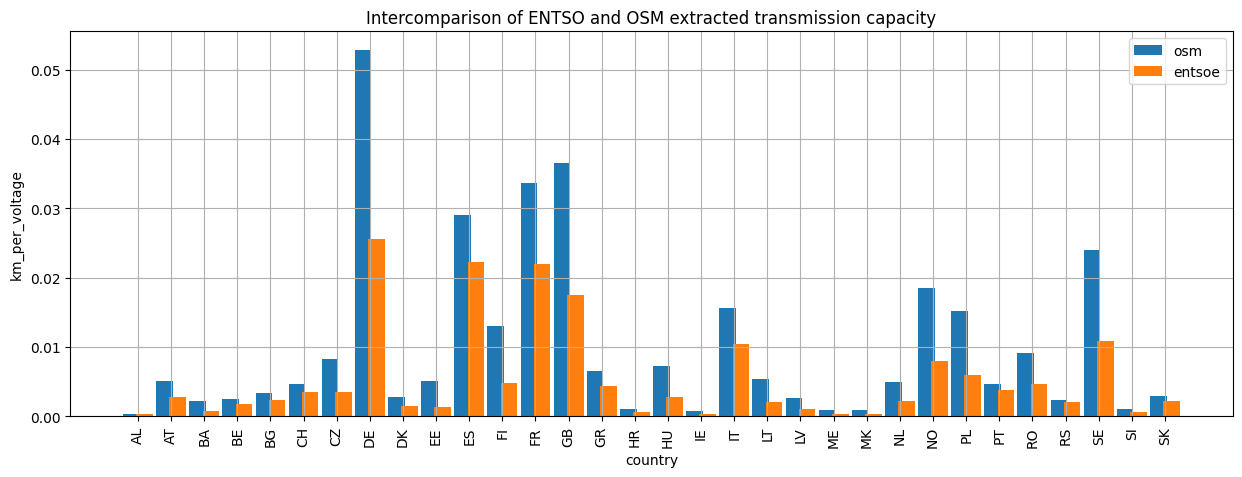

In [9]:
plt.figure(figsize=(15,5))

entsoe_x_axis = np.arange(len(entsoe_merged_country_stats_km_per_voltage['country']))
osm_x_axis = np.arange(len(osm_country_stats_km_per_voltage['country']))

plt.bar(osm_x_axis - 0.2, osm_country_stats_km_per_voltage['km_per_voltage'], 0.5, label='osm')
plt.bar(entsoe_x_axis + 0.2, entsoe_merged_country_stats_km_per_voltage['km_per_voltage'], 0.5, label='entsoe')

plt.xticks(entsoe_x_axis, entsoe_merged_country_stats_km_per_voltage['country'])
plt.xticks(rotation=90)
plt.title('Intercomparison of ENTSO and OSM extracted transmission capacity')
plt.xlabel('country')
plt.ylabel('km_per_voltage')
plt.grid(True)
plt.legend()
plt.show()

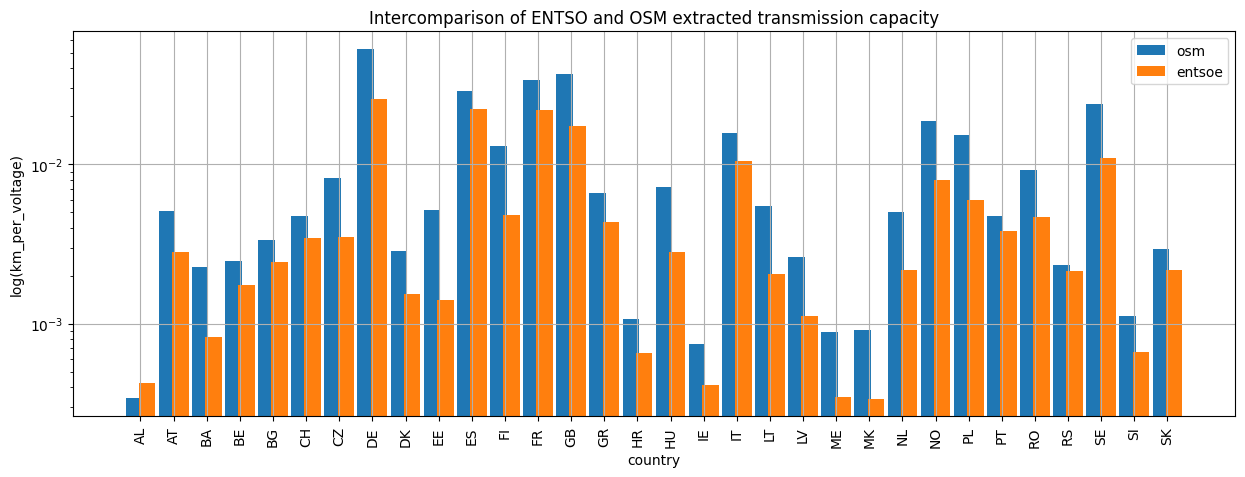

In [10]:
plt.figure(figsize=(15,5))

entsoe_x_axis = np.arange(len(entsoe_merged_country_stats_km_per_voltage['country']))
osm_x_axis = np.arange(len(osm_country_stats_km_per_voltage['country']))

plt.bar(osm_x_axis - 0.2, osm_country_stats_km_per_voltage['km_per_voltage'], 0.5, label='osm')
plt.bar(entsoe_x_axis + 0.2, entsoe_merged_country_stats_km_per_voltage['km_per_voltage'], 0.5, label='entsoe')

plt.xticks(entsoe_x_axis, entsoe_merged_country_stats_km_per_voltage['country'])
plt.xticks(rotation=90)
plt.title('Intercomparison of ENTSO and OSM extracted transmission capacity')
plt.xlabel('country')
plt.yscale('log')
plt.ylabel('log(km_per_voltage)')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# grouping the OSM-data and PyPSA-Eur data by length to plot total length by voltage levels
osm_voltage_stats_length = osm.lines[['v_nom', 'length']][osm.lines.dc == False].groupby(['v_nom'])[['length']].sum()
osm_voltage_stats_length.reset_index(inplace=True)

entsoe_voltage_stats_length = entsoe.lines[['v_nom', 'length']].groupby(['v_nom'])[['length']].sum()
entsoe_voltage_stats_length.reset_index(inplace=True)

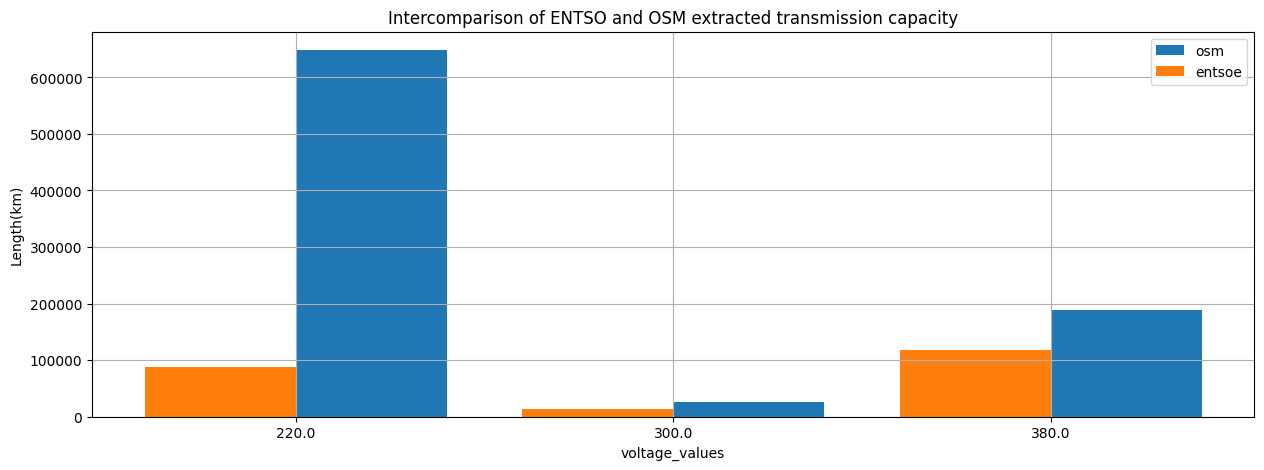

In [12]:
plt.figure(figsize=(15,5))

entsoe_x_axis = np.arange(len(entsoe_voltage_stats_length['v_nom']))
osm_x_axis = np.arange(len(osm_voltage_stats_length['v_nom']))

plt.bar(osm_x_axis + 0.2, osm_voltage_stats_length.length, 0.4, label='osm')
plt.bar(entsoe_x_axis - 0.2, entsoe_voltage_stats_length.length, 0.4, label='entsoe')

plt.xticks(osm_x_axis, osm_voltage_stats_length['v_nom'])
plt.xticks(rotation=0)
plt.title('Intercomparison of ENTSO and OSM extracted transmission capacity')
plt.xlabel('voltage_values')
plt.ylabel('Length(km)')
plt.grid('True')
plt.legend()
plt.show()

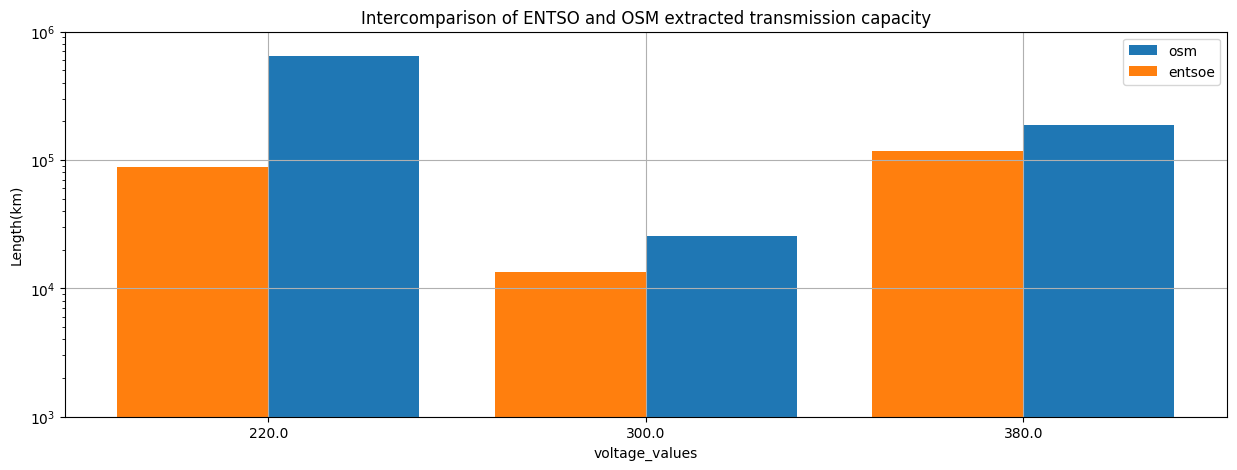

In [13]:
plt.figure(figsize=(15,5))

entsoe_x_axis = np.arange(len(entsoe_voltage_stats_length['v_nom']))
osm_x_axis = np.arange(len(osm_voltage_stats_length['v_nom']))

plt.bar(osm_x_axis + 0.2, osm_voltage_stats_length.length, 0.4, label='osm')
plt.bar(entsoe_x_axis - 0.2, entsoe_voltage_stats_length.length, 0.4, label='entsoe')

plt.xticks(osm_x_axis, osm_voltage_stats_length['v_nom'])
plt.xticks(rotation=0)
plt.title('Intercomparison of ENTSO and OSM extracted transmission capacity')
plt.xlabel('voltage_values')
plt.ylabel('Length(km)')
plt.yscale('log')
plt.grid('True')
plt.yticks([1000, 10000,100000,1000000])
plt.legend()
plt.show()